In [59]:
from sys import argv as cmdLineArgs
from xml.etree.ElementTree import ElementTree
import numpy as np
import itertools
from warnings import warn

In [60]:
STATE_UNSET = 0
STATE_INTERP = 1
STATE_LABELED = 2
stateFromText = {'0':STATE_UNSET, '1':STATE_INTERP, '2':STATE_LABELED}

OCC_UNSET = 255  # -1 as uint8
OCC_VISIBLE = 0
OCC_PARTLY = 1
OCC_FULLY = 2
occFromText = {'-1':OCC_UNSET, '0':OCC_VISIBLE, '1':OCC_PARTLY, '2':OCC_FULLY}

TRUNC_UNSET = 255  # -1 as uint8, but in xml files the value '99' is used!
TRUNC_IN_IMAGE = 0
TRUNC_TRUNCATED = 1
TRUNC_OUT_IMAGE = 2
TRUNC_BEHIND_IMAGE = 3
truncFromText = {'99':TRUNC_UNSET, '0':TRUNC_IN_IMAGE, '1':TRUNC_TRUNCATED, \
                  '2':TRUNC_OUT_IMAGE, '3': TRUNC_BEHIND_IMAGE}


In [61]:
class Tracklet(object):
    r""" representation an annotated object track 
  
    Tracklets are created in function parseXML and can most conveniently used as follows:

    for trackletObj in parseXML(trackletFile):
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
            ... your code here ...
        #end: for all frames
    #end: for all tracklets

    absoluteFrameNumber is in range [firstFrame, firstFrame+nFrames[
    amtOcclusion and amtBorders could be None

    You can of course also directly access the fields objType (string), size (len-3 ndarray), firstFrame/nFrames (int), 
    trans/rots (nFrames x 3 float ndarrays), states/truncs (len-nFrames uint8 ndarrays), occs (nFrames x 2 uint8 ndarray),
    and for some tracklets amtOccs (nFrames x 2 float ndarray) and amtBorders (nFrames x 3 float ndarray). The last two
    can be None if the xml file did not include these fields in poses
    """

    objectType = None
    size = None  # len-3 float array: (height, width, length)
    firstFrame = None
    trans = None   # n x 3 float array (x,y,z)
    rots = None    # n x 3 float array (x,y,z)
    states = None  # len-n uint8 array of states
    occs = None    # n x 2 uint8 array  (occlusion, occlusion_kf)
    truncs = None  # len-n uint8 array of truncation
    amtOccs = None    # None or (n x 2) float array  (amt_occlusion, amt_occlusion_kf)
    amtBorders = None    # None (n x 3) float array  (amt_border_l / _r / _kf)
    nFrames = None

    def __init__(self):
        r""" create Tracklet with no info set """
        self.size = np.nan*np.ones(3, dtype=float)

    def __str__(self):
        r""" return human-readable string representation of tracklet object

        called implicitly in 
        print trackletObj
        or in 
        text = str(trackletObj)
        """
        return '[Tracklet over {0} frames for {1}]'.format(self.nFrames, self.objectType)

    def __iter__(self):
        r""" returns an iterator that yields tuple of all the available data for each frame 

        called whenever code iterates over a tracklet object, e.g. in 
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in trackletObj:
          ...do something ...
        or
        trackDataIter = iter(trackletObj)
        """
        if self.amtOccs is None:
            return itertools.zip_longest(self.trans, self.rots, self.states, self.occs, self.truncs, \
                itertools.repeat(None), itertools.repeat(None), range(self.firstFrame, self.firstFrame+self.nFrames))
        else:
            return itertools.zip_longest(self.trans, self.rots, self.states, self.occs, self.truncs, \
                self.amtOccs, self.amtBorders, range(self.firstFrame, self.firstFrame+self.nFrames))
#end: class Tracklet


In [62]:

def parseXML(trackletFile):
    r""" parse tracklet xml file and convert results to list of Tracklet objects

    :param trackletFile: name of a tracklet xml file
    :returns: list of Tracklet objects read from xml file
    """

    # convert tracklet XML data to a tree structure
    eTree = ElementTree()
    print('parsing tracklet file', trackletFile)
    with open(trackletFile) as f:
        eTree.parse(f)

    # now convert output to list of Tracklet objects
    trackletsElem = eTree.find('tracklets')
    tracklets = []
    trackletIdx = 0
    nTracklets = None
    for trackletElem in trackletsElem:
        #print('track:', trackletElem.tag)
        if trackletElem.tag == 'count':
            nTracklets = int(trackletElem.text)
            print('file contains', nTracklets, 'tracklets')
        elif trackletElem.tag == 'item_version':
            pass
        elif trackletElem.tag == 'item':
#             print('tracklet {0} of {1}'.format(trackletIdx, nTracklets))
            # a tracklet
            newTrack = Tracklet()
            isFinished = False
            hasAmt = False
            frameIdx = None
            for info in trackletElem:
                #print('trackInfo:', info.tag)
                if isFinished:
                    raise ValueError('more info on element after finished!')
                if info.tag == 'objectType':
                    newTrack.objectType = info.text
                elif info.tag == 'h':
                    newTrack.size[0] = float(info.text)
                elif info.tag == 'w':
                    newTrack.size[1] = float(info.text)
                elif info.tag == 'l':
                    newTrack.size[2] = float(info.text)
                elif info.tag == 'first_frame':
                    newTrack.firstFrame = int(info.text)
                elif info.tag == 'poses':
                    # this info is the possibly long list of poses
                    for pose in info:
                        #print('trackInfoPose:', pose.tag)
                        if pose.tag == 'count':   # this should come before the others
                            if newTrack.nFrames is not None:
                                raise ValueError('there are several pose lists for a single track!')
                            elif frameIdx is not None:
                                raise ValueError('?!')
                            newTrack.nFrames = int(pose.text)
                            newTrack.trans  = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            newTrack.rots   = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            newTrack.states = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
                            newTrack.occs   = np.nan * np.ones((newTrack.nFrames, 2), dtype='uint8')
                            newTrack.truncs = np.nan * np.ones(newTrack.nFrames, dtype='uint8')
                            newTrack.amtOccs = np.nan * np.ones((newTrack.nFrames, 2), dtype=float)
                            newTrack.amtBorders = np.nan * np.ones((newTrack.nFrames, 3), dtype=float)
                            frameIdx = 0
                        elif pose.tag == 'item_version':
                            pass
                        elif pose.tag == 'item':
                            # pose in one frame
                            if frameIdx is None:
                                raise ValueError('pose item came before number of poses!')
                            for poseInfo in pose:
#                                 print('trackInfoPoseInfo:', poseInfo.tag)
                                if poseInfo.tag == 'tx':
                                    newTrack.trans[frameIdx, 0] = float(poseInfo.text)
                                elif poseInfo.tag == 'ty':
                                    newTrack.trans[frameIdx, 1] = float(poseInfo.text)
                                elif poseInfo.tag == 'tz':
                                    newTrack.trans[frameIdx, 2] = float(poseInfo.text)
                                elif poseInfo.tag == 'rx':
                                    newTrack.rots[frameIdx, 0] = float(poseInfo.text)
                                elif poseInfo.tag == 'ry':
                                    newTrack.rots[frameIdx, 1] = float(poseInfo.text)
                                elif poseInfo.tag == 'rz':
                                    newTrack.rots[frameIdx, 2] = float(poseInfo.text)
                                elif poseInfo.tag == 'state':
                                    newTrack.states[frameIdx] = stateFromText[poseInfo.text]
                                elif poseInfo.tag == 'occlusion':
                                    newTrack.occs[frameIdx, 0] = occFromText[poseInfo.text]
                                elif poseInfo.tag == 'occlusion_kf':
                                    newTrack.occs[frameIdx, 1] = occFromText[poseInfo.text]
                                elif poseInfo.tag == 'truncation':
                                    newTrack.truncs[frameIdx] = truncFromText[poseInfo.text]
                                elif poseInfo.tag == 'amt_occlusion':
                                    newTrack.amtOccs[frameIdx,0] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_occlusion_kf':
                                    newTrack.amtOccs[frameIdx,1] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_l':
                                    newTrack.amtBorders[frameIdx,0] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_r':
                                    newTrack.amtBorders[frameIdx,1] = float(poseInfo.text)
                                    hasAmt = True
                                elif poseInfo.tag == 'amt_border_kf':
                                    newTrack.amtBorders[frameIdx,2] = float(poseInfo.text)
                                    hasAmt = True
                                else:
                                    raise ValueError('unexpected tag in poses item: {0}!'.format(poseInfo.tag))
                            frameIdx += 1
                        else:
                            raise ValueError('unexpected pose info: {0}!'.format(pose.tag))
                elif info.tag == 'finished':
                    isFinished = True
                else:
                    raise ValueError('unexpected tag in tracklets: {0}!'.format(info.tag))
            #end: for all fields in current tracklet

            # some final consistency checks on new tracklet
            if not isFinished:
                warn('tracklet {0} was not finished!'.format(trackletIdx))
            if newTrack.nFrames is None:
                warn('tracklet {0} contains no information!'.format(trackletIdx))
            elif frameIdx != newTrack.nFrames:
                warn('tracklet {0} is supposed to have {1} frames, but perser found {1}!'.format(\
                    trackletIdx, newTrack.nFrames, frameIdx))
            if np.abs(newTrack.rots[:,:2]).sum() > 1e-16:
                warn('track contains rotation other than yaw!')

            # if amtOccs / amtBorders are not set, set them to None
            if not hasAmt:
                newTrack.amtOccs = None
                newTrack.amtBorders = None

            # add new tracklet to list
            tracklets.append(newTrack)
            trackletIdx += 1

        else:
            raise ValueError('unexpected tracklet info')
    #end: for tracklet list items

    print('loaded', trackletIdx, 'tracklets')

    # final consistency check
    if trackletIdx != nTracklets:
        warn('according to xml information the file has {0} tracklets, but parser found {1}!'.format(nTracklets, trackletIdx))

    return tracklets
    #end: function parseXML

In [75]:
from os.path import join, expanduser
import readline
myTrackletFile = join('../data/2011_09_26', '2011_09_26_drive_0048_sync', 'tracklet_labels.xml')
tracklets = parseXML(myTrackletFile)

tracklet = tracklets[1]
h,w,l = tracklet.size
print(h,w,l)
tracklet_box = lwh_to_box(l, w, h)

parsing tracklet file ../data/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
file contains 8 tracklets
loaded 8 tracklets
1.3982387 1.5867531 3.887013


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


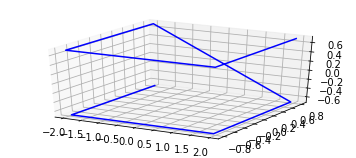

In [90]:
def draw(data):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    %matplotlib inline
    f2 = plt.figure()
#     ax = Axes3D(f2)
#     ax.scatter(data[0], data[1], data[2])
    ax = f2.gca(projection='3d')
    ax.set_aspect("equal")
    ax.plot3D(data[0], data[1],data[2], color="b")
    f2.show()
draw(tracklet_box)

[ 0.          0.          3.16876542]


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


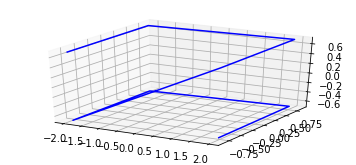

In [93]:
# print(tracklet.trans, tracklet.rots)
rot = tracklet.rots[0]
trans = tracklet.trans[0]
print(rot)
yaw = rot[2]
rot_mat = np.array([
        [np.cos(yaw), -np.sin(yaw), 0.0],
        [np.sin(yaw), np.cos(yaw), 0.0],
        [0.0, 0.0, 1.0]])
rot_data1 = np.dot(rot_mat, tracklet_box)
draw(rot_data1)
# print(np.tile(trans, (8, 1)).T)
rot_data2 = rot_data1 + np.tile(trans, (8, 1)).T

[[ 10.43284391  10.38973275   6.50415467   6.54726583  10.43284391
   10.38973275   6.50415467   6.54726583]
 [  4.52531805   6.11148539   6.0058775    4.41971016   4.52531805
    6.11148539   6.0058775    4.41971016]
 [ -2.55574658  -2.55574658  -2.55574658  -2.55574658  -1.15750788
   -1.15750788  -1.15750788  -1.15750788]]


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


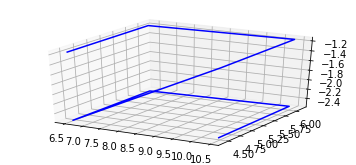

In [95]:
draw(rot_data2)
print(rot_data2)

In [63]:
def example(kittiDir=None, drive=None):

    from os.path import join, expanduser
    import readline    # makes raw_input behave more fancy
    # from xmlParser import parseXML, TRUNC_IN_IMAGE, TRUNC_TRUNCATED

    DEFAULT_DRIVE = '2011_09_26_drive_0001'
    twoPi = 2.*np.pi

    # get dir names
    if kittiDir is None:
        kittiDir = expanduser(raw_input('please enter kitti base dir (e.g. ~/path/to/kitti): ').strip())
    if drive is None:
        drive = raw_input('please enter drive name (default {0}): '.format(DEFAULT_DRIVE)).strip()
        if len(drive) == 0:
            drive = DEFAULT_DRIVE

    # read tracklets from file
    myTrackletFile = join(kittiDir, drive, 'tracklet_labels.xml')
    tracklets = parseXML(myTrackletFile)

    # loop over tracklets
    for iTracklet, tracklet in enumerate(tracklets):
        print('tracklet {0: 3d}: {1}'.format(iTracklet, tracklet))

        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h,w,l = tracklet.size
        trackletBox = np.array([ # in velodyne coordinates around zero point and without orientation yet\
            [-l/2, -l/2,  l/2, l/2, -l/2, -l/2,  l/2, l/2], \
            [ w/2, -w/2, -w/2, w/2,  w/2, -w/2, -w/2, w/2], \
            [ 0.0,  0.0,  0.0, 0.0,    h,     h,   h,   h]])

        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber \
            in tracklet:

            # determine if object is in the image; otherwise continue
            if truncation not in (TRUNC_IN_IMAGE, TRUNC_TRUNCATED):
                continue

            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]   # other rotations are 0 in all xml files I checked
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([\
                [np.cos(yaw), -np.sin(yaw), 0.0], \
                [np.sin(yaw),  np.cos(yaw), 0.0], \
                [        0.0,          0.0, 1.0]])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8,1)).T

            # calc yaw as seen from the camera (i.e. 0 degree = facing away from cam), as opposed to 
            #   car-centered yaw (i.e. 0 degree = same orientation as car).
            #   makes quite a difference for objects in periphery!
            # Result is in [0, 2pi]
            x, y, z = translation
            yawVisual = ( yaw - np.arctan2(y, x) ) % twoPi
            print(yawVisual)

        #end: for all frames in track
    #end: for all tracks
#end: function example


In [65]:
from shapely.geometry import Polygon
from collections import Counter
import numpy as np
import argparse
import os
import sys
import yaml

In [70]:
def lwh_to_box(l, w, h):
    box = np.array([
        [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
        [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
        # FIXME constrain height to range from ground or relative to centroid like l & w?
        [-h / 2, -h / 2, -h / 2, -h / 2, h / 2, h / 2, h / 2, h / 2],
        #[0.0, 0.0, 0.0, 0.0, h, h, h, h]
    ])
    return box

In [ ]:
def iou_3d_yaw(pred_vol, pred_box, gt_vol, gt_box):
    """
    A simplified calculation of 3d bounding box intersection
    over union. It is assumed that the bounding box is only rotated
    around Z axis (yaw) from an axis-aligned box.
    :param pred_vol: predicted obstacle volume
    :param pred_box: predicted obstacle bounding box
    :param gt_vol: ground truth obstacle volume
    :param gt_box: ground truth obstacle bounding box
    :return: iou float, intersection volume float
    """
    # height (Z) overlap
    pred_min_h = np.min(pred_box[2])
    pred_max_h = np.max(pred_box[2])
    gt_min_h = np.min(gt_box[2])
    gt_max_h = np.max(gt_box[2])
    max_of_min = np.max([pred_min_h, gt_min_h])
    min_of_max = np.min([pred_max_h, gt_max_h])
    z_intersection = np.max([0, min_of_max - max_of_min])
    if z_intersection == 0:
        return 0, 0

    # oriented XY overlap
    pred_xy_poly = Polygon(zip(*pred_box[0:2, 0:4]))
    gt_xy_poly = Polygon(zip(*gt_box[0:2, 0:4]))
    xy_intersection = gt_xy_poly.intersection(pred_xy_poly).area
    if xy_intersection == 0:
        return 0, 0

    intersection = z_intersection * xy_intersection
    union = pred_vol + gt_vol - intersection
    iou = intersection / union
    return iou, intersection

In [ ]:
class Obs(object):

    def __init__(self, tracklet_idx, object_type, box_vol, oriented_box):
        self.tracklet_idx = tracklet_idx
        self.object_type = object_type
        self.box_vol = box_vol
        self.oriented_box = oriented_box

    def __repr__(self):
        return str(self.tracklet_idx) + ' ' + str(self.object_type)

In [ ]:
class EvalFrame(object):

    def __init__(self):
        self.gt_obs = []
        self.pred_obs = []

    def score(self, intersection_count, union_count, pr_at_ious):
        # Perform IOU calculations between all gt and predicted obstacle pairings and greedily match those
        # with the largest IOU. Possibly other matching algorithms will work better/be more efficient.
        # NOTE: This is not a tracking oriented matching like MOTA, predicted -> gt affinity context
        # would need to be passed between frame evaluations for that.

        intersections = []
        fn = set(range(len(self.gt_obs)))  # gt idx for gt that don't have any intersecting pred
        fp = set(range(len(self.pred_obs)))  # pred idx for pred not intersecting any gt

        # Compute IOU between all obstacle gt <-> prediction pairing possibilities (of same obj type)
        for p_idx, p in enumerate(self.pred_obs):
            for g_idx, g in enumerate(self.gt_obs):
                if p.object_type == g.object_type:
                    iou_val, intersection_vol = iou_3d_yaw(
                        p.box_vol, p.oriented_box,
                        g.box_vol, g.oriented_box)
                    if iou_val > 0:
                        intersections.append((iou_val, intersection_vol, p_idx, g_idx))

        # Traverse calculated intersections, greedily consume intersections with largest overlap first,
        # summing volumes and marking TP/FP/FN at specific IOU thresholds as we go.
        intersections.sort(key=lambda x: x[0], reverse=True)
        for iou_val, intersection_vol, p_idx, g_idx in intersections:
            if g_idx in fn and p_idx in fp:
                fn.remove(g_idx)  # consume the groundtruth
                fp.remove(p_idx)  # consume the prediction
                obs = self.gt_obs[g_idx]
                #print('IOU: ', iou_val, intersection_vol)
                intersection_count[obs.object_type] += intersection_vol
                union_count[obs.object_type] += obs.box_vol + self.pred_obs[p_idx].box_vol - intersection_vol
                for iou_threshold in pr_at_ious.keys():
                    if iou_val > iou_threshold:
                        pr_at_ious[iou_threshold]['TP'] += 1
                    else:
                        # It's already determined at this point that this is the highest IOU score
                        # there is for this match and another match for these two bbox won't be considered.
                        # Thus both the gt and prediction should be considered unmatched.
                        pr_at_ious[iou_threshold]['FP'] += 1
                        pr_at_ious[iou_threshold]['FN'] += 1

        # sum remaining false negative volume (unmatched ground truth box volume)
        for g_idx in fn:
            obs = self.gt_obs[g_idx]
            union_count[obs.object_type] += obs.box_vol
            for iou_threshold in pr_at_ious.keys():
                pr_at_ious[iou_threshold]['FN'] += 1

        # sum remaining false positive volume (unmatched prediction volume)
        for p_idx in fp:
            obs = self.pred_obs[p_idx]
            union_count[obs.object_type] += obs.box_vol
            for iou_threshold in pr_at_ious.keys():
                pr_at_ious[iou_threshold]['FP'] += 1


In [ ]:
def generate_boxes(tracklets):
    for tracklet_idx, tracklet in enumerate(tracklets):
        h, w, l = tracklet.size
        box_vol = h * w * l
        tracklet_box = lwh_to_box(l, w, h) # will create a 3D bounding box
        
        # print(tracklet_box)
        frame_idx = tracklet.first_frame
        for trans, rot in zip(tracklet.trans, tracklet.rots):
            # calc 3D bound box in capture vehicle oriented coordinates
            yaw = rot[2]  # rotations besides yaw should be 0
            rot_mat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]])
            oriented_box = np.dot(rot_mat, tracklet_box) + np.tile(trans, (8, 1)).T
            yield frame_idx, tracklet_idx, tracklet.object_type, box_vol, oriented_box
            frame_idx += 1


In [ ]:
def main():
    parser = argparse.ArgumentParser(description='Evaluate two tracklet files.')
    parser.add_argument('prediction', type=str, nargs='?', default='tracklet_labels.xml',
        help='Predicted tracklet label filename')
    
    parser.add_argument('groundtruth', type=str, nargs='?', default='tracklet_labels_gt.xml',
        help='Groundtruth tracklet label filename')
    
    parser.add_argument('-o', '--outdir', type=str, nargs='?', default=None, help='Output folder')
    
    parser.add_argument('-d', dest='debug', action='store_true', help='Debug print enable')
    parser.set_defaults(debug=False)
    args = parser.parse_args()
    output_dir = args.outdir

    pred_file = args.prediction
    if not os.path.exists(pred_file):
        sys.stderr.write('Error: Prediction file %s not found.\n' % pred_file)
        exit(-1)

    gt_file = args.groundtruth
    if not os.path.exists(gt_file):
        sys.stderr.write('Error: Ground-truth file %s not found.\n' % gt_file)
        exit(-1)

    pred_tracklets = parseXML(pred_file)
    if not pred_tracklets:
        sys.stderr.write('Error: No Tracklets parsed for predictions.\n')
        exit(-1)

    gt_tracklets = parseXML(gt_file)
    if not gt_tracklets:
        sys.stderr.write('Error: No Tracklets parsed for ground truth.\n')
        exit(-1)

    num_gt_frames = 0
    for gt_tracklet in gt_tracklets:
        num_gt_frames = max(num_gt_frames, gt_tracklet.first_frame + gt_tracklet.num_frames)

    num_pred_frames = 0
    for p_idx, pred_tracklet in enumerate(pred_tracklets):
        num_pred_frames = max(num_pred_frames, pred_tracklet.first_frame + pred_tracklet.num_frames)
        # FIXME START TEST HACK
        if False:
            blah = np.random.normal(0, 0.3, pred_tracklet.trans.shape)
            pred_tracklets[p_idx].trans = pred_tracklets[p_idx].trans + blah
        # FIXME END HACK

    num_frames = max(num_gt_frames, num_pred_frames)
    if not num_frames:
        print('Error: No frames to evaluate')
        exit(-1)
        
    eval_frames = [EvalFrame() for _ in range(num_frames)]

    for frame_idx, tracklet_idx, object_type, box_vol, oriented_box in generate_boxes(gt_tracklets):
        eval_frames[frame_idx].gt_obs.append(Obs(tracklet_idx, object_type, box_vol, oriented_box))

    for frame_idx, tracklet_idx, object_type, box_vol, oriented_box in generate_boxes(pred_tracklets):
        eval_frames[frame_idx].pred_obs.append(Obs(tracklet_idx, object_type, box_vol, oriented_box))

    iou_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    pr_at_ious = {k: Counter() for k in iou_thresholds}

    intersection_count = Counter()
    union_count = Counter()
    for frame_idx in range(num_frames):
        #  calc scores
        eval_frames[frame_idx].score(
            intersection_count,
            union_count,
            pr_at_ious)

    results_table = {'iou_per_obj': {}, 'pr_per_iou': {}}

    # FIXME determine how we want to combined IOU scores between object classes:
    # - combine volumes across all classes before ratio (vehicles dominate pedestrians)
    # - simple mean of per class ratio (current)
    # - weighted mean of per class ratio
    iou_sum = 0.0
    for k in intersection_count.keys():
        iou = intersection_count[k] / union_count[k]
        results_table['iou_per_obj'][k] = float(iou)
        iou_sum += iou
    results_table['iou_per_obj']['All'] = float(iou_sum / len(intersection_count))

    # FIXME add support for per class P/R scores?
    # NOTE P/R scores need further analysis given their use with the greedy pred - gt matching
    for k, v in pr_at_ious.items():
        p = v['TP'] / (v['TP'] + v['FP']) if v['TP'] else 0.0
        r = v['TP'] / (v['TP'] + v['FN']) if v['TP'] else 0.0
        # f1 = 2 * (p * r) / (p + r) if (p + r != 0) else 0.0
        results_table['pr_per_iou'][k] = {'precision': p, 'recall': r}

    print('\nResults')
    print(yaml.safe_dump(results_table, default_flow_style=False, explicit_start=True))

    if output_dir is not None:
        with open(os.path.join(output_dir, 'iou_per_obj.csv'), 'w') as f:
            f.write('object_type,iou\n')
            [f.write('{0},{1}\n'.format(k, v))
             for k, v in sorted(results_table['iou_per_obj'].items(), key=lambda x: x[0])]
        with open(os.path.join(output_dir, 'pr_per_iou.csv'), 'w') as f:
            f.write('iou_threshold,p,r\n')
            [f.write('{0},{1},{2}\n'.format(k, v['precision'], v['recall']))
             for k, v in sorted(results_table['pr_per_iou'].items(), key=lambda x: x[0])]

In [64]:
example('../data/2011_09_26', '2011_09_26_drive_0048_sync')

parsing tracklet file ../data/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
file contains 8 tracklets
loaded 8 tracklets
tracklet   0: [Tracklet over 11 frames for Van]
2.93493059125
2.90358863432
2.86244481451
2.80640615748
2.7392446275
2.63102882429
tracklet   1: [Tracklet over 6 frames for Car]
2.61248033634
2.57010667281
2.52139269495
2.4651925349
2.40020225515
2.32501427664
tracklet   2: [Tracklet over 7 frames for Car]
3.5736296028
3.64740454067
3.74426248581
tracklet   3: [Tracklet over 22 frames for Car]
0.113475936853
0.117796696713
0.122395353191
0.127181365935
0.13148503
0.136258412513
0.140390270517
0.144923620039
0.152210036796
0.160247170232
0.169154190523
0.179827164635
0.192030934165
0.206060410657
0.22228930971
0.241197426494
0.260244208875
0.280319846517
0.305031379157
0.33575210781
0.37441778484
0.423815011382
tracklet   4: [Tracklet over 22 frames for Car]
3.03978016085
3.03764716986
3.03041489136
3.02253443897
3.01503986179
3.00723769741
2.99946906815
2

In [ ]:
# when somebody runs this file as a script: 
#   run example if no arg or only 'example' was given as arg
#   otherwise run parseXML
if __name__ == "__main__":
    # cmdLineArgs[0] is 'parseTrackletXML.py'
    if len(cmdLineArgs) < 2:
        example()
    elif (len(cmdLineArgs) == 2) and (cmdLineArgs[1] == 'example'):
        example()
    else:
        parseXML(*cmdLineArgs[1:])
